# <center>CITS5508 Lab sheet 4</center>

**Name:** Alastair Mory<br>
**Student number:** 21120848<br>


<br><b>Contents</b><br>
[1 E. Coli Classification Data](#1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Data Visualisation and Statistics](#1.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.2 Data Preprocessing](#1.2)<br>
[2 Classification](#2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Support Vector Machine](#2.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Logistic Regression](#2.2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Stochastic Gradient Descent](#2.3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Ensemble Voting](#2.4)<br>
[3 Conclusion](#3)<br>

In [1]:
from typing import Any

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [2]:
# Read data in
data = pd.read_csv('winequality-white.csv', sep=';')

# Display example rows
data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


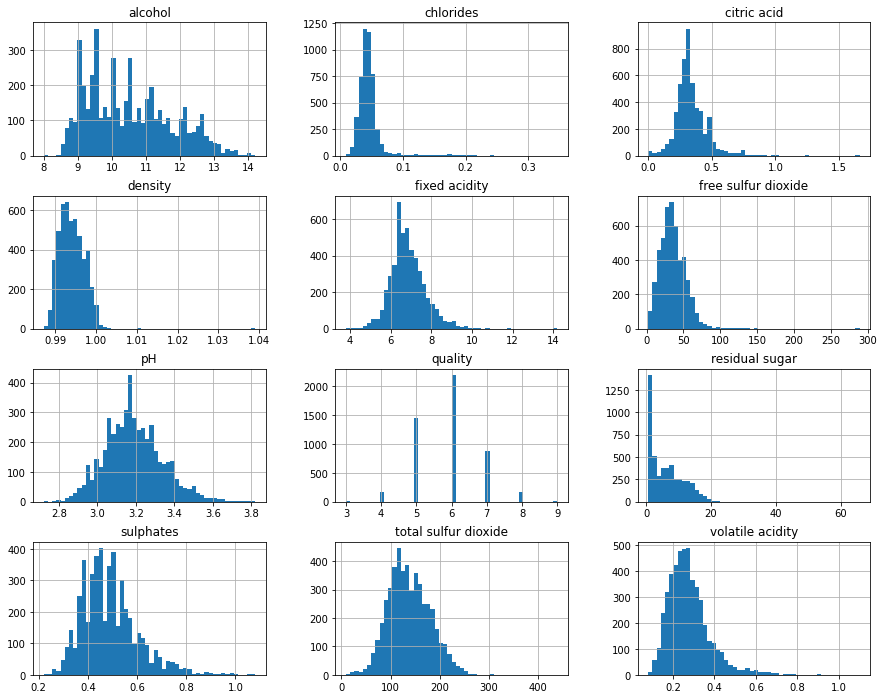

In [55]:
# Histogram of numerical features
_ = data.hist(bins=50, figsize=(15,12))


In [4]:
# Statistics for numerical features
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [5]:
# Perform 85/15 train test split
train, test = train_test_split(data,
                               test_size=0.15,
                               train_size=0.85)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train_y = train['quality']
test_y = test['quality']

train_x = train.drop(columns=['quality'])
test_x = test.drop(columns=['quality'])

In [51]:
def get_results(regressor,  # untrained regressor,
                  train_x: pd.DataFrame, train_y: pd.Series,
                  test_x: pd.DataFrame, test_y: pd.Series):
    results = {
        'y_train_true': train_y,
        'y_train_pred': [],
        'y_test_true': test_y,
        'y_test_pred': []
    }
    
    # Train regressor
    regressor.fit(train_x, train_y)
    
    # Run regressor prediction
    for y_stage in regressor.staged_predict(train_x):
        y_pred = np.round(y_stage)
        results['y_train_pred'].append(y_pred)
        
    for y_stage in regressor.staged_predict(test_x):
        y_pred = np.round(y_stage)
        results['y_test_pred'].append(y_pred)
        
    return results

def show_mse(results,  # dict returned by get_results()
             regressor_name='Regressor') -> None:
    """
    Calculate and plot MSEs from results. 
    """
    n_stages = len(results['y_train_pred'])
    
    train_mse = []
    for y_pred in results['y_train_pred']:
        train_mse.append(mean_squared_error(results['y_train_true'], y_pred))
    test_mse = []
    for y_pred in results['y_test_pred']:
        test_mse.append(mean_squared_error(results['y_test_true'], y_pred))
        
    
    fig = plt.figure()

    plt.scatter(np.arange(6),train_mse)
    plt.scatter(np.arange(6),test_mse)
    plt.plot(train_mse, label="Train MSE")
    plt.plot(test_mse, label="Test MSE")
    
    plt.xlabel("Boost iteration")
    plt.ylabel("MSE")
    plt.xticks(np.arange(6), np.arange(1, 7))
    plt.legend()
    
    return fig

In [48]:
regr_1 = AdaBoostRegressor(base_estimator=SVR(), n_estimators=6)

regr_1_results = get_results(regr_1, train_x, train_y, test_x, test_y)

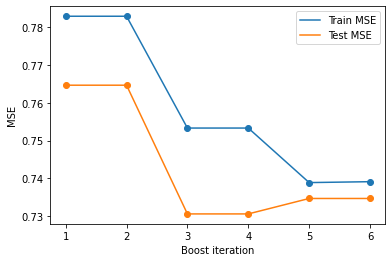

In [52]:
fig = show_mse(regr_1_results)